In [232]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os
%matplotlib inline

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [233]:
raw_test_data = pd.read_csv("/Users/weilu/Research/data/test_data/test_data_4.csv")
raw_data = raw_test_data.groupby("Name").get_group("T0792")

In [234]:
my_validation_set = raw_test_data.groupby("Name").get_group("T0803")

In [235]:
raw_test_data.columns

Index(['Step', 'Qw', 'Rw', 'VTotal', 'QGO', 'Burial', 'Water', 'Rama', 'Chain',
       'Chi', 'DSSP', 'P_AP', 'Helix', 'Frag_Mem', 'GDT', 'Name', 'Good'],
      dtype='object')

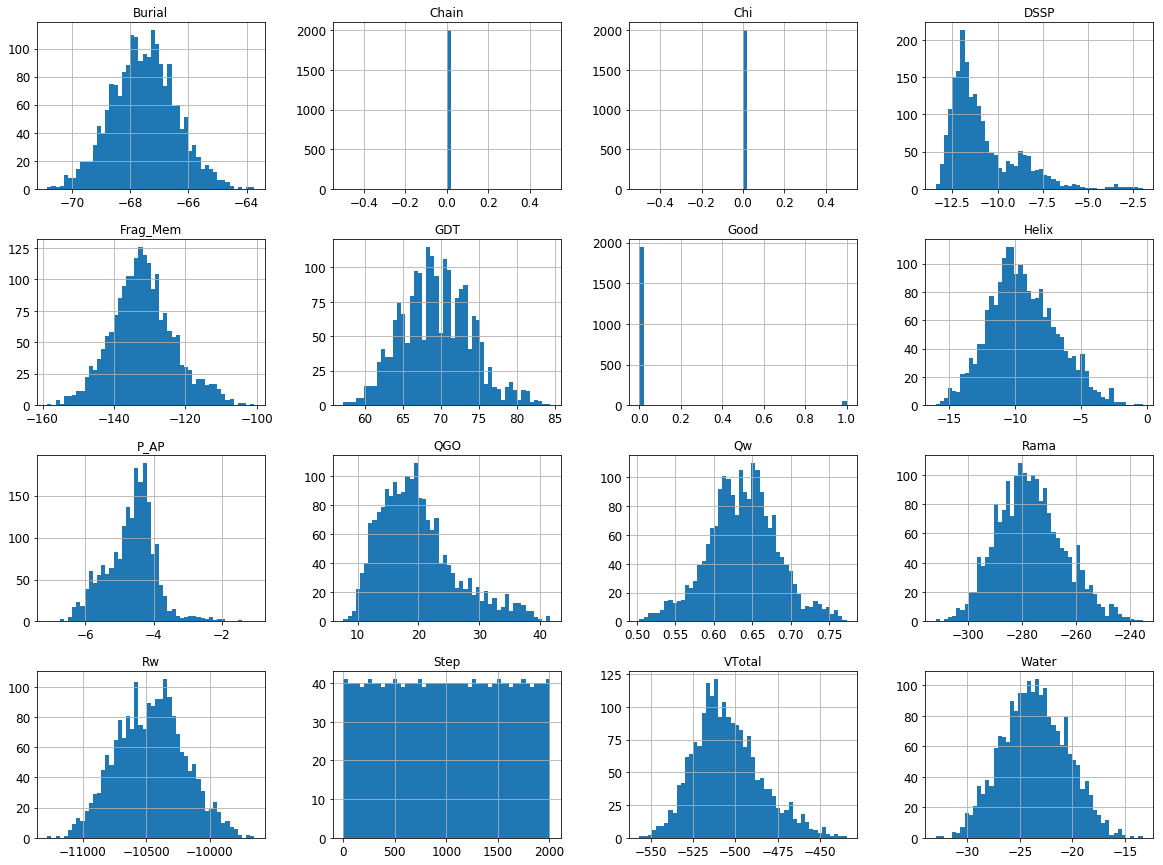

In [236]:
new_raw_data.hist(bins=50, figsize=(20,15))
plt.show()

In [237]:
# FEATURES = ["Rw", "VTotal", "QGO"]
# FEATURES = ["Rw", "VTotal", "QGO", "Burial", "Frag_Mem", "Water"]
# FEATURES = list(raw_test_data.columns[2:-3])
FEATURES = ['Rw',
 'VTotal',
 'QGO',
 'Burial',
 'Water',
 'Rama',
 'DSSP',
 'P_AP',
 'Helix',
 'Frag_Mem']
LABEL = "Good"

In [238]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import PolynomialFeatures
# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
class RemoveFirstFrame(BaseEstimator, TransformerMixin):
    def __init__(self, frame):
        self.frame = frame
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.query(f"Step % {frame} != 1")

In [239]:
# I want to start with the simplest linear regression

In [240]:
num_attribs = FEATURES
cat_attribs = [LABEL]
frame = 201
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('std_scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=1, include_bias=False))
    ])
cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs))
    ])

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])
my_full_pipeline = Pipeline([
        ('removeFirstFrame', RemoveFirstFrame(frame)),
        ('featureSelection', full_pipeline)
])

In [241]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(raw_data, raw_data[LABEL]):
    strat_train_set = raw_data.iloc[train_index]
    strat_test_set = raw_data.iloc[test_index]
# strat_test_set[LABEL].value_counts() / len(strat_test_set)
X_train = my_full_pipeline.fit_transform(strat_train_set)
X_test = my_full_pipeline.fit_transform(strat_test_set)
train_y = X_train[:,-1]
train_set = X_train[:,:-1]
test_y = X_test[:,-1]
test_set = X_test[:,:-1]

In [242]:
X_validation = my_full_pipeline.fit_transform(my_validation_set)
validation_y = X_validation[:,-1]
validation_set = X_validation[:,:-1]

In [203]:
validation_set.shape

(2000, 11)

In [206]:
train_set[:,0 ]

array([ 1.23073771,  0.11140719,  0.44455607, ...,  0.42673219,
       -0.13135711, -0.70121062])

In [244]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
p = 0.5
log_clf = LogisticRegression(random_state=142, class_weight={0:p, 1:(1-p)})
rnd_clf = RandomForestClassifier(random_state=432, class_weight={0:p, 1:(1-p)})
svm_clf = SVC(probability=True, random_state=412, class_weight={0:p, 1:(1-p)})

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
log_clf.fit(train_set, train_y)
rnd_clf.fit(train_set, train_y)
svm_clf.fit(train_set, train_y)
voting_clf.fit(train_set, train_y)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight={0: 0.5, 1: 0.5}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=142,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)), ('r...f',
  max_iter=-1, probability=True, random_state=412, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None)

In [246]:
n = 10
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
#     y_pred = clf.predict(train_set)
    prob= clf.predict_proba(train_set)[:,1]
    position_of_top_n = prob.argsort()[-n:][::-1]
    threshold = prob[position_of_top_n][-1]
    predict_y = np.zeros(len(train_y),)
    predict_y[position_of_top_n] = 1
#     predict_y = (test > threshold)
#     print(threshold)
    cm = confusion_matrix(train_y, predict_y)
#     print(clf.__class__.__name__, "\n", accuracy_score(train_y, predict_y))
    print(clf.__class__.__name__, "\n", cm)

LogisticRegression 
 [[1567    0]
 [  31   10]]
RandomForestClassifier 
 [[1567    0]
 [  31   10]]
SVC 
 [[1567    0]
 [  31   10]]
VotingClassifier 
 [[1567    0]
 [  31   10]]


In [175]:
sum(train_y)

39.0

In [247]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)
n = 3
for train_index, test_index in skfolds.split(train_set, train_y):
    clone_clf = clone(rnd_clf)
    X_train_folds = train_set[train_index]
    y_train_folds = (train_y[train_index])
    X_test_fold = train_set[test_index]
    y_test_fold = (train_y[test_index])

    clone_clf.fit(X_train_folds, y_train_folds)
#     y_pred = clone_clf.predict(X_test_fold)
    prob= clf.predict_proba(X_test_fold)[:,1]
    position_of_top_n = prob.argsort()[-n:][::-1]
    threshold = prob[position_of_top_n][-1]
    y_pred = np.zeros(len(y_test_fold),)
    y_pred[position_of_top_n] = 1
    cm = confusion_matrix(y_test_fold, y_pred)
    print(cm)

[[523   0]
 [ 11   3]]
[[522   0]
 [ 11   3]]
[[522   0]
 [ 10   3]]


In [248]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)
n = 3
for train_index, test_index in skfolds.split(train_set, train_y):
    clone_clf = clone(log_clf)
    X_train_folds = train_set[train_index]
    y_train_folds = (train_y[train_index])
    X_test_fold = train_set[test_index]
    y_test_fold = (train_y[test_index])

    clone_clf.fit(X_train_folds, y_train_folds)
#     y_pred = clone_clf.predict(X_test_fold)
    prob= clf.predict_proba(X_test_fold)[:,1]
    position_of_top_n = prob.argsort()[-n:][::-1]
    threshold = prob[position_of_top_n][-1]
    y_pred = np.zeros(len(y_test_fold),)
    y_pred[position_of_top_n] = 1
    cm = confusion_matrix(y_test_fold, y_pred)
    print(cm)

[[523   0]
 [ 11   3]]
[[522   0]
 [ 11   3]]
[[522   0]
 [ 10   3]]


In [258]:
def compute_with_my_score_function(p=0.9, degree=3):
    num_attribs = FEATURES
    cat_attribs = [LABEL]
    frame = 201
    num_pipeline = Pipeline([
            ('selector', DataFrameSelector(num_attribs)),
            ('std_scaler', StandardScaler()),
            ('poly', PolynomialFeatures(degree=1, include_bias=False))
        ])
    cat_pipeline = Pipeline([
            ('selector', DataFrameSelector(cat_attribs))
        ])

    full_pipeline = FeatureUnion(transformer_list=[
            ("num_pipeline", num_pipeline),
            ("cat_pipeline", cat_pipeline),
        ])
    my_full_pipeline = Pipeline([
            ('removeFirstFrame', RemoveFirstFrame(frame)),
            ('featureSelection', full_pipeline)
    ])
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    for train_index, test_index in split.split(raw_data, raw_data[LABEL]):
        strat_train_set = raw_data.iloc[train_index]
        strat_test_set = raw_data.iloc[test_index]
    # strat_test_set[LABEL].value_counts() / len(strat_test_set)
    X_train = my_full_pipeline.fit_transform(strat_train_set)
    X_test = my_full_pipeline.fit_transform(strat_test_set)
    train_y = X_train[:,-1]
    train_set = X_train[:,:-1]
    test_y = X_test[:,-1]
    test_set = X_test[:,:-1]

    log_clf = LogisticRegression(random_state=142, class_weight={0:p, 1:(1-p)})
    rnd_clf = RandomForestClassifier(random_state=432, class_weight={0:p, 1:(1-p)})
    svm_clf = SVC(probability=True, random_state=412, class_weight={0:p, 1:(1-p)})
    voting_clf = VotingClassifier(
        estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
        voting='soft')

#     voting_clf.fit(train_set, train_y)
    n = 10
    for cl_name, clf in zip(("lr", "rf", "svc", "voting"), (log_clf, rnd_clf, svm_clf, voting_clf)):
#     for cl_name, clf in ("voting", voting_clf):
        clf.fit(train_set, train_y)
        my_evaluation = 1.0
        another_evaluation = 0.0
        for name, data in raw_test_data.groupby("Name"):
#             print(name)

            split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
            for validation_index, test_index in split.split(data, data[LABEL]):
                validation_set = data.iloc[validation_index]
                strat_test_set = data.iloc[test_index]
            # strat_test_set[LABEL].value_counts() / len(strat_test_set)
            X_validation = full_pipeline.fit_transform(validation_set)
            validation_y = X_validation[:,-1]
            validation_set = X_validation[:,:-1]
            clf.fit(train_set, train_y)
            test= clf.predict_proba(validation_set)[:,1]
            position_of_top_n = test.argsort()[-n:][::-1]
            threshold = test[position_of_top_n][-1]
            predict_y = np.zeros(len(validation_y),)
            predict_y[position_of_top_n] = 1
        #     predict_y = (test > threshold)
    #         print(threshold)
            cm = confusion_matrix(validation_y, predict_y)
#             print(cm)
            precision = cm[1][1] / (cm[1][1] + cm[0][1])
#             print(name,  " precision", precision,end = " ")
            if name != "T0766" and name != "T0833":
                my_evaluation *= precision
                another_evaluation += precision
#         print("")
        print("classifier:", cl_name, ", p:",p, ", degree", degree, ", score", my_evaluation, ", another score", another_evaluation)
    return (cl_name, p, degree, my_evaluation)

In [270]:
def compute_with_my_score_function(p=0.9, degree=3):
    num_attribs = FEATURES
    cat_attribs = [LABEL]
    frame = 201
    num_pipeline = Pipeline([
            ('selector', DataFrameSelector(num_attribs)),
            ('std_scaler', StandardScaler()),
            ('poly', PolynomialFeatures(degree=1, include_bias=False))
        ])
    cat_pipeline = Pipeline([
            ('selector', DataFrameSelector(cat_attribs))
        ])

    full_pipeline = FeatureUnion(transformer_list=[
            ("num_pipeline", num_pipeline),
            ("cat_pipeline", cat_pipeline),
        ])
    my_full_pipeline = Pipeline([
            ('removeFirstFrame', RemoveFirstFrame(frame)),
            ('featureSelection', full_pipeline)
    ])
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    for train_index, test_index in split.split(raw_data, raw_data[LABEL]):
        strat_train_set = raw_data.iloc[train_index]
        strat_test_set = raw_data.iloc[test_index]
    # strat_test_set[LABEL].value_counts() / len(strat_test_set)
    X_train = my_full_pipeline.fit_transform(strat_train_set)
    X_test = my_full_pipeline.fit_transform(strat_test_set)
    train_y = X_train[:,-1]
    train_set = X_train[:,:-1]
    test_y = X_test[:,-1]
    test_set = X_test[:,:-1]

    log_clf = LogisticRegression(random_state=1142, class_weight={0:p, 1:(1-p)})
    rnd_clf = RandomForestClassifier(random_state=1432, class_weight={0:p, 1:(1-p)})
    svm_clf = SVC(probability=True, random_state=1412, class_weight={0:p, 1:(1-p)})
    voting_clf = VotingClassifier(
        estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
        voting='soft')

#     voting_clf.fit(train_set, train_y)
    n = 10
    for cl_name, clf in zip(("lr", "rf", "svc", "voting"), (log_clf, rnd_clf, svm_clf, voting_clf)):
#     for cl_name, clf in ("voting", voting_clf):
        clf.fit(train_set, train_y)
        my_evaluation = 1.0
        another_evaluation = 0.0
        for name, data in raw_test_data.groupby("Name"):
#             print(name)

            split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
            for validation_index, test_index in split.split(data, data[LABEL]):
                validation_set = data.iloc[validation_index]
                strat_test_set = data.iloc[test_index]
            # strat_test_set[LABEL].value_counts() / len(strat_test_set)
            X_validation = full_pipeline.fit_transform(validation_set)
            validation_y = X_validation[:,-1]
            validation_set = X_validation[:,:-1]
            clf.fit(train_set, train_y)
            test= clf.predict_proba(validation_set)[:,1]
            position_of_top_n = test.argsort()[-n:][::-1]
            threshold = test[position_of_top_n][-1]
            predict_y = np.zeros(len(validation_y),)
            predict_y[position_of_top_n] = 1
        #     predict_y = (test > threshold)
    #         print(threshold)
            cm = confusion_matrix(validation_y, predict_y)
#             print(cm)
            precision = cm[1][1] / (cm[1][1] + cm[0][1])
#             print(name,  " precision", precision,end = " ")
            if name != "T0766" and name != "T0833":
                my_evaluation *= precision
                another_evaluation += precision
#         print("")
        print("classifier:", cl_name, ", p:",p, ", degree", degree, ", score", my_evaluation, ", another score", another_evaluation)
    return (cl_name, p, degree, my_evaluation)

In [271]:
def myGridSerach():
    p_list = [0.9, 0.8, 0.7, 0.5, 0.1]
    degree_list = [3, 2, 1]
#     degree_list = [1]
#     p_list = [0.1, 0.8, 0.9, 0.95]
#     degree_list = [1, 2, 3]
#     p_list = [0.1, 0.15, 0.2, 0.5, 0.7, 0.8, 0.85, 0.9, 0.95]
#     degree_list = [1, 2, 3, 4]
    result = []
    for p in p_list:
        for degree in degree_list:
            result += [compute_with_my_score_function(p, degree)]
            

In [272]:
myGridSerach()

classifier: lr , p: 0.9 , degree 3 , score 0.0 , another score 1.4
classifier: rf , p: 0.9 , degree 3 , score 0.012 , another score 3.7
classifier: svc , p: 0.9 , degree 3 , score 0.0 , another score 1.8
classifier: voting , p: 0.9 , degree 3 , score 0.012 , another score 3.7
classifier: lr , p: 0.9 , degree 2 , score 0.0 , another score 1.4
classifier: rf , p: 0.9 , degree 2 , score 0.012 , another score 3.7
classifier: svc , p: 0.9 , degree 2 , score 0.0 , another score 1.8
classifier: voting , p: 0.9 , degree 2 , score 0.012 , another score 3.7
classifier: lr , p: 0.9 , degree 1 , score 0.0 , another score 1.4
classifier: rf , p: 0.9 , degree 1 , score 0.012 , another score 3.7
classifier: svc , p: 0.9 , degree 1 , score 0.0 , another score 1.8
classifier: voting , p: 0.9 , degree 1 , score 0.012 , another score 3.7
classifier: lr , p: 0.8 , degree 3 , score 0.0 , another score 1.4
classifier: rf , p: 0.8 , degree 3 , score 0.00576 , another score 3.4
classifier: svc , p: 0.8 , degr

In [268]:
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
num_attribs = FEATURES
cat_attribs = [LABEL]
frame = 201
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('std_scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=1, include_bias=False))
    ])
cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs))
    ])

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])
my_full_pipeline = Pipeline([
        ('removeFirstFrame', RemoveFirstFrame(frame)),
        ('featureSelection', full_pipeline)
])

# split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
# for train_index, test_index in split.split(raw_data, raw_data[LABEL]):
#     strat_train_set = raw_data.iloc[train_index]
#     strat_test_set = raw_data.iloc[test_index]
# # strat_test_set[LABEL].value_counts() / len(strat_test_set)
# X_train = my_full_pipeline.fit_transform(strat_train_set)
# X_test = my_full_pipeline.fit_transform(strat_test_set)
# train_y = X_train[:,-1]
# train_set = X_train[:,:-1]
# test_y = X_test[:,-1]
# test_set = X_test[:,:-1]
train_set, test_set = train_test_split(raw_data, test_size=0.2, random_state=42)
X_train = full_pipeline.fit_transform(train_set)
X_test = full_pipeline.fit_transform(test_set)
#     X_train = full_pipeline.fit_transform(raw_data)
train_y = X_train[:,-1]
train_set = X_train[:,:-1]
p = 0.1
log_clf = LogisticRegression(random_state=142, class_weight={0:p, 1:(1-p)})
rnd_clf = RandomForestClassifier(random_state=432, class_weight={0:p, 1:(1-p)})
svm_clf = SVC(probability=True, random_state=412, class_weight={0:p, 1:(1-p)})

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
log_clf.fit(train_set, train_y)
n = 6
for name, data in raw_test_data.groupby("Name"):
    print(name)
    X = full_pipeline.fit_transform(data)
    eval_y = X[:,-1]
    eval_set = X[:,:-1]
    test= log_clf.predict_proba(eval_set)[:,1]
    position_of_top_n = test.argsort()[-n:][::-1]
    threshold = test[position_of_top_n][-1]
    predict_y = np.zeros(len(eval_y),)
    predict_y[position_of_top_n] = 1
    with open("/Users/weilu/Research/data/structure_selector/nov17_{}_results_2.csv".format(name), "w") as f:
        f.write("Result\n")
        for i in test:
            f.write(str(i) + "\n")
#     predict_y = (test > threshold)
#     print(threshold)
    print(confusion_matrix(eval_y, predict_y))



1MBA
[[1956    5]
 [  48    1]]
T0766
[[1956    5]
 [  48    1]]
T0784
[[1955    6]
 [  49    0]]
T0792
[[1959    2]
 [  45    4]]
T0803
[[1956    5]
 [  48    1]]
T0815
[[1953    4]
 [  51    2]]
T0833
[[1928    5]
 [  48    1]]
T251
[[1955    6]
 [  49    0]]


In [275]:
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
num_attribs = FEATURES
cat_attribs = [LABEL]
frame = 201
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('std_scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=1, include_bias=False))
    ])
cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs))
    ])

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])
my_full_pipeline = Pipeline([
        ('removeFirstFrame', RemoveFirstFrame(frame)),
        ('featureSelection', full_pipeline)
])

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(raw_data, raw_data[LABEL]):
    strat_train_set = raw_data.iloc[train_index]
    strat_test_set = raw_data.iloc[test_index]
# strat_test_set[LABEL].value_counts() / len(strat_test_set)
X_train = my_full_pipeline.fit_transform(strat_train_set)
X_test = my_full_pipeline.fit_transform(strat_test_set)
train_y = X_train[:,-1]
train_set = X_train[:,:-1]
test_y = X_test[:,-1]
test_set = X_test[:,:-1]

p = 0.9
log_clf = LogisticRegression(random_state=142, class_weight={0:p, 1:(1-p)})
rnd_clf = RandomForestClassifier(random_state=432, class_weight={0:p, 1:(1-p)})
svm_clf = SVC(probability=True, random_state=412, class_weight={0:p, 1:(1-p)})

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
log_clf.fit(train_set, train_y)
n = 6
for name, data in raw_test_data.groupby("Name"):
    print(name)
    X = full_pipeline.fit_transform(data)
    eval_y = X[:,-1]
    eval_set = X[:,:-1]
    test= log_clf.predict_proba(eval_set)[:,1]
    position_of_top_n = test.argsort()[-n:][::-1]
    threshold = test[position_of_top_n][-1]
    predict_y = np.zeros(len(eval_y),)
    predict_y[position_of_top_n] = 1
    with open("/Users/weilu/Research/data/structure_selector/{}_results_new.csv".format(name), "w") as f:
        f.write("Result\n")
        for i in test:
            f.write(str(i) + "\n")
#     predict_y = (test > threshold)
#     print(threshold)
    print(confusion_matrix(eval_y, predict_y))




1MBA
[[1957    4]
 [  47    2]]
T0766
[[1955    6]
 [  49    0]]
T0784
[[1955    6]
 [  49    0]]
T0792
[[1960    1]
 [  44    5]]
T0803
[[1956    5]
 [  48    1]]
T0815
[[1953    4]
 [  51    2]]
T0833
[[1928    5]
 [  48    1]]
T251
[[1955    6]
 [  49    0]]


In [24]:
n = 10
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
#     y_pred = clf.predict(train_set)
    prob= clf.predict_proba(test_set)[:,1]
    position_of_top_n = prob.argsort()[-n:][::-1]
    threshold = prob[position_of_top_n][-1]
    predict_y = np.zeros(len(test_y),)
    predict_y[position_of_top_n] = 1
#     predict_y = (test > threshold)
#     print(threshold)
    cm = confusion_matrix(test_y, predict_y)
#     print(clf.__class__.__name__, "\n", accuracy_score(train_y, predict_y))
    print(clf.__class__.__name__, "\n", cm)

LogisticRegression 
 [[391   3]
 [  1   7]]
RandomForestClassifier 
 [[389   5]
 [  3   5]]
SVC 
 [[390   4]
 [  2   6]]
VotingClassifier 
 [[389   5]
 [  3   5]]


In [15]:
def compute_with_my_score_function(p=0.9, degree=3):
    num_attribs = FEATURES
    cat_attribs = LABEL
    num_pipeline = Pipeline([
            ('selector', DataFrameSelector(num_attribs)),
            ('std_scaler', StandardScaler()),
            ('poly', PolynomialFeatures(degree=degree, include_bias=False))
        ])
    cat_pipeline = Pipeline([
            ('selector', DataFrameSelector(cat_attribs))
        ])

    full_pipeline = FeatureUnion(transformer_list=[
            ("num_pipeline", num_pipeline),
            ("cat_pipeline", cat_pipeline),
        ])
    train_set, test_set = train_test_split(raw_data, test_size=0.2, random_state=42)
    X_train = full_pipeline.fit_transform(train_set)
    X_test = full_pipeline.fit_transform(test_set)
#     X_train = full_pipeline.fit_transform(raw_data)
    train_y = X_train[:,-1]
    train_set = X_train[:,:-1]
    log_clf = LogisticRegression(random_state=142, class_weight={0:p, 1:(1-p)})
    rnd_clf = RandomForestClassifier(random_state=432, class_weight={0:p, 1:(1-p)})
    svm_clf = SVC(probability=True, random_state=412, class_weight={0:p, 1:(1-p)})
    voting_clf = VotingClassifier(
        estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
        voting='soft')

#     voting_clf.fit(train_set, train_y)
    n = 10
    for cl_name, clf in zip(("lr", "rf", "svc", "voting"), (log_clf, rnd_clf, svm_clf, voting_clf)):
#     for cl_name, clf in ("voting", voting_clf):
        my_evaluation = 1.0
        another_evaluation = 0.0
        for name, data in raw_test_data.groupby("Name"):
#             print(name)
            X = full_pipeline.fit_transform(data)
            validation_data, test_data = train_test_split(X, test_size=0.6, random_state=124)

            validation_y = validation_data[:,-1]
            validation_set = validation_data[:,:-1]
            clf.fit(train_set, train_y)
            test= clf.predict_proba(validation_set)[:,1]
            position_of_top_n = test.argsort()[-n:][::-1]
            threshold = test[position_of_top_n][-1]
            predict_y = np.zeros(len(validation_y),)
            predict_y[position_of_top_n] = 1
        #     predict_y = (test > threshold)
    #         print(threshold)
            cm = confusion_matrix(validation_y, predict_y)
#             print(cm)
            precision = cm[1][1] / (cm[1][1] + cm[0][1])
#             print(name,  " precision", precision,end = " ")
            if name != "T0766" and name != "T0833":
                my_evaluation *= precision
                another_evaluation += precision
#         print("")
        print("classifier:", cl_name, ", p:",p, ", degree", degree, ", score", my_evaluation, ", another score", another_evaluation)
    return (cl_name, p, degree, my_evaluation)

In [16]:
def myGridSerach():
    p_list = [0.9, 0.8, 0.7, 0.5, 0.1]
    degree_list = [3, 2, 1]
#     p_list = [0.1, 0.8, 0.9, 0.95]
#     degree_list = [1, 2, 3]
#     p_list = [0.1, 0.15, 0.2, 0.5, 0.7, 0.8, 0.85, 0.9, 0.95]
#     degree_list = [1, 2, 3, 4]
    result = []
    for p in p_list:
        for degree in degree_list:
            result += [compute_with_my_score_function(p, degree)]
            

In [17]:
myGridSerach()

classifier: lr , p: 0.9 , degree 3 , score 0.01008 , another score 3.0
classifier: rf , p: 0.9 , degree 3 , score 0.00576 , another score 3.1
classifier: svc , p: 0.9 , degree 3 , score 0.0 , another score 1.8
classifier: voting , p: 0.9 , degree 3 , score 0.0 , another score 3.0
classifier: lr , p: 0.9 , degree 2 , score 0.0 , another score 1.6
classifier: rf , p: 0.9 , degree 2 , score 0.00216 , another score 2.6
classifier: svc , p: 0.9 , degree 2 , score 0.00048 , another score 2.3
classifier: voting , p: 0.9 , degree 2 , score 0.0036 , another score 2.7
classifier: lr , p: 0.9 , degree 1 , score 0.0 , another score 2.0
classifier: rf , p: 0.9 , degree 1 , score 0.00448 , another score 3.0
classifier: svc , p: 0.9 , degree 1 , score 0.000216 , another score 2.0
classifier: voting , p: 0.9 , degree 1 , score 0.00336 , another score 2.9
classifier: lr , p: 0.8 , degree 3 , score 0.0075 , another score 2.8
classifier: rf , p: 0.8 , degree 3 , score 0.0 , another score 2.1
classifier: 

In [274]:
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
num_attribs = FEATURES
cat_attribs = [LABEL]
degree = 3
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('std_scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=degree, include_bias=False))
    ])
cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs))
    ])

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

# raw_data = raw_test_data.groupby("Name").get_group("1MBA")
train_set, test_set = train_test_split(raw_data, test_size=0.2, random_state=42)
X_train = full_pipeline.fit_transform(train_set)
X_test = full_pipeline.fit_transform(test_set)
train_y = X_train[:,-1]
train_set = X_train[:,:-1]
# test_y = X_test[:,-1]
# test_set = X_test[:,:-1]

p = 0.9
log_clf = LogisticRegression(random_state=142, class_weight={0:p, 1:(1-p)})
rnd_clf = RandomForestClassifier(random_state=432, class_weight={0:p, 1:(1-p)})
svm_clf = SVC(probability=True, random_state=412, class_weight={0:p, 1:(1-p)})

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
log_clf.fit(train_set, train_y)
n = 6
for name, data in raw_test_data.groupby("Name"):
    print(name)
    X = full_pipeline.fit_transform(data)
    eval_y = X[:,-1]
    eval_set = X[:,:-1]
    test= log_clf.predict_proba(eval_set)[:,1]
    position_of_top_n = test.argsort()[-n:][::-1]
    threshold = test[position_of_top_n][-1]
    predict_y = np.zeros(len(eval_y),)
    predict_y[position_of_top_n] = 1
    with open("/Users/weilu/Research/data/structure_selector/{}_results_new.csv".format(name), "w") as f:
        f.write("Result\n")
        for i in test:
            f.write(str(i) + "\n")
#     predict_y = (test > threshold)
#     print(threshold)
    print(confusion_matrix(eval_y, predict_y))



1MBA
[[1955    6]
 [  49    0]]
T0766
[[1956    5]
 [  48    1]]
T0784
[[1956    5]
 [  48    1]]
T0792
[[1961    0]
 [  43    6]]
T0803
[[1956    5]
 [  48    1]]
T0815
[[1955    2]
 [  49    4]]
T0833
[[1927    6]
 [  49    0]]
T251
[[1956    5]
 [  48    1]]


In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
pca = PCA(n_components = 0.95)
stdscaler = StandardScaler
stdscaler.fit(test)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1